Applied Deep Learning Final project Fall 2019:

*   Shuai Hao (sh3831)
*   Bhaskar Ghosh (bg2625)










## Model training and evaluation
In this notebook, we further process the data by truncating and padding the sequences. And we define, train and evaluate our bidirectional LSTM model. HPC doesn't support the lastest version of tensorflow, so there are a few warnings in the output.

Install graphviz, rouge and pydot

In [0]:
!pip install graphviz --user

You are using pip version 8.1.2, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
!pip install rouge --user

You are using pip version 8.1.2, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
!pip install pydot --user

You are using pip version 8.1.2, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Using HPC
The following computations, training and evaluation was done on High Performance Cluster at Columbia.

In [0]:
!pwd

/rigel/home/sh3831


Import required libraries

In [0]:
import random
import time
import math
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from rouge import Rouge 

import tensorflow as tf

/rigel/home/sh3831/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/rigel/home/sh3831/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/rigel/home/sh3831/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/rigel/home/sh3831/.local/lib/python3.5/site-packages/tensorflow/python/f

In [0]:
tf.test.is_gpu_available()

False

#### Maximum sequence length
We experimented with different values for MAX_SEQ_LEN, starting with 20. We settled for 100, after trying out 20, 50, 100, 500 and 1000. For 500 and 1000 the training accuracy was higher for a single batch but overall Rouge score was lower. We got 96% accuracy for MAX_SEQ_LEN = 100.

In [0]:
# SOS_TOKEN = '<sos>'
# EOS_TOKEN = '<eos>'
MAX_SEQ_LEN = 100

## Load the train and validation data

In [0]:
train_embedding_path = '/rigel/home/sh3831/cnn-dailymail/sentence_embeddings/train/'
valid_embedding_path = '/rigel/home/sh3831/cnn-dailymail/sentence_embeddings/valid/'
train_label_path = '/rigel/home/sh3831/cnn-dailymail/labels/train/'
valid_label_path = '/rigel/home/sh3831/cnn-dailymail/labels/valid/'

In [0]:
# train_label_files and valid_label_files have the same name with the embedding files, so we don't need to read them again
train_embedding_files = os.listdir(train_embedding_path)
valid_embedding_files = os.listdir(valid_embedding_path)
# train_label_files = os.listdir(train_label_path)
# valid_label_files = os.listdir(valid_label_path)

In [0]:
len(train_embedding_files), len(valid_embedding_files)

(23037, 5000)

## Create the dataset

Setting the basic variables for training.

In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
units = 1024
EMBEDDING_SIZE = 200
# vocab_inp_size = len(inp_lang.word_index)+1
# vocab_tar_size = len(targ_lang.word_index)+1

### Function to create dataset from given embeddings and labels
We use it to create datasets for training and validation

In [0]:
def create_dataset(embedding, label):
    dataset = tf.data.Dataset.from_tensor_slices((embedding, label)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

### Function to fetch embeddings and labels previously processed
We use this function to fetch embeddings and labels for training and validation data

In [0]:
def fetch_data(files, embedding_path, label_path):
    label_list = []
    embedding_list = []
    for file_name in files:
        embedding_temp = []
        with open(embedding_path + file_name) as embed_json_file:
            embed_data = json.load(embed_json_file)
            for key, value in embed_data.items():
                embedding_temp.append(value)
        if len(embedding_temp) > MAX_SEQ_LEN:
            padded_embed_value = embedding_temp[:MAX_SEQ_LEN].copy()
        elif len(embedding_temp) < MAX_SEQ_LEN:
            for i in range(MAX_SEQ_LEN- len(embedding_temp)):
                embedding_temp.append(np.zeros(EMBEDDING_SIZE).tolist())
            padded_embed_value = embedding_temp.copy()
        else:
            padded_embed_value = embedding_temp.copy()

        embedding_list.append(padded_embed_value)
        if label_path != '':
            with open(label_path + file_name) as label_json_file:
                label_data = json.load(label_json_file)
                label_value = label_data['labels']
            label_list.append(label_value)

        if len(embedding_list) % 1000 == 0:
            print(len(embedding_list))

    return embedding_list, label_list

#### Fetching embeddings and labels for validation data

In [0]:
embedding_valid, label_valid = fetch_data(valid_embedding_files, valid_embedding_path, valid_label_path)

1000
2000
3000
4000
5000


In [0]:
len(embedding_valid), len(label_valid)

(5000, 5000)

#### Converting validation embeddings and labels to tensors
Also, labels need to be padded to be of equal length. In some cases labels are shorter because number of sentences in the article are less than MAX_SEQ_LEN, which we have set as 100.



In [0]:
embedding_valid = tf.convert_to_tensor(embedding_valid)

label_valid = tf.keras.preprocessing.sequence.pad_sequences(label_valid, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
label_valid = tf.convert_to_tensor(label_valid)

In [0]:
embedding_valid.shape, label_valid.shape

(TensorShape([5000, 20, 200]), TensorShape([5000, 20]))

#### Converting training embeddings and labels to tensors

In [0]:
embedding_train, label_train = fetch_data(train_embedding_files, train_embedding_path, train_label_path)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


Verifying the amount of data available

In [0]:
len(embedding_train), len(label_train)

(23037, 23037)

Converting training embeddings and labels to tensors. As with validation data, we pad the labels here as well.

In [0]:
embedding_train = tf.convert_to_tensor(embedding_train)

label_train = tf.keras.preprocessing.sequence.pad_sequences(label_train, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
label_train = tf.convert_to_tensor(label_train)

In [0]:
embedding_train.shape, label_train.shape

(TensorShape([23037, 20, 200]), TensorShape([23037, 20]))

#### Creating the training and validation datasets using embeddings and labels

In [0]:
train_ds = create_dataset(embedding_train, label_train)
val_ds = create_dataset(embedding_valid, label_valid)


Creating an example batch of size 64

In [0]:
example_input_batch, example_target_batch = next(iter(train_ds))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 20, 200]), TensorShape([64, 20]))

In [0]:
example_input_batch, example_target_batch

(<tf.Tensor: id=34, shape=(64, 20, 200), dtype=float32, numpy=
 array([[[ 1.19126707e-01,  1.02685206e-01, -6.63583651e-02, ...,
          -1.64312925e-02, -2.11342499e-01,  2.94691250e-02],
         [ 1.61275402e-01,  2.34291375e-01, -1.25948628e-02, ...,
           1.11244068e-01, -2.03864664e-01,  8.24729800e-02],
         [-4.03197929e-02,  1.13423169e-01, -9.32936594e-02, ...,
           5.76375015e-02,  3.51726264e-02,  4.65227067e-02],
         ...,
         [-9.31013450e-02,  2.19360858e-01,  6.03526644e-02, ...,
           8.99249613e-02, -1.92768145e-02,  7.37334043e-02],
         [ 3.91648225e-02,  1.98101133e-01, -8.53032544e-02, ...,
           3.90994214e-02, -7.28416303e-03,  4.79806252e-02],
         [ 7.22724721e-02,  1.00568779e-01, -8.18326399e-02, ...,
          -6.87590390e-02, -8.80567208e-02,  3.81180607e-02]],
 
        [[ 1.55355260e-01,  3.39423180e-01,  2.19849162e-02, ...,
          -1.18725665e-01, -7.68353343e-02, -1.00816665e-02],
         [ 2.76925236e-0

## Define the bidirectional LSTM model

In [0]:
from tensorflow.keras.layers import Dense, Flatten, Input, LSTM, Bidirectional, Activation, Dropout
from tensorflow.keras.models import Model, Sequential

We added Dropout to the model after we saw that the accuracy was hovering around 50%. Accuracy improved considerably after adding Dropout.

In [0]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(MAX_SEQ_LEN, EMBEDDING_SIZE)))
model.add(Bidirectional(LSTM(32)))
# model.add(Bidirectional(LSTM(16)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(MAX_SEQ_LEN, activation='relu'))
model.add(Dropout(0.5))
model.add(Activation('softmax'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20, 128)           135680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation (Activation)      (None, 100)               0

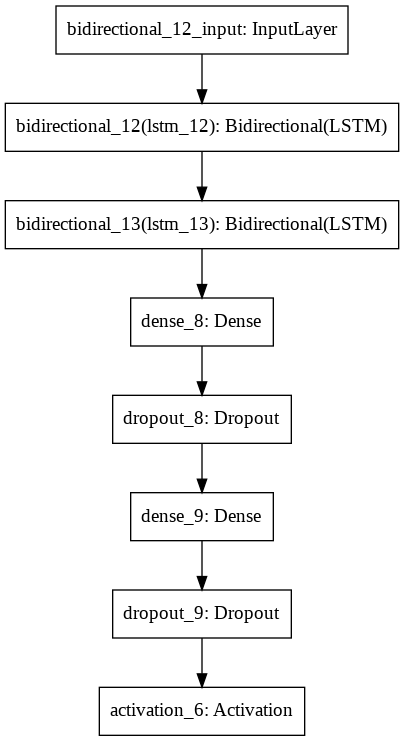

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

Using the adam optimizer and binary_crossentropy as our loss function. We tried categorical_crossentropy as a loss function as well, but the accuracy was poor in comparison. We saw a similar trend with the SGD optimizer and decided to go with adam and binary_crossentropy. We tried random_normal and zeros initializers, but did not get better results. Hence, we decided to stick with the default glorot_uniform initializer.

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the model using a single batch
To start off, we trained the model on a single batch of training data. The batch size was 64. We ran the training for 200 epochs. Max. accuracy was around 96%. Increasing number of epochs did not increase accuracy by much.



In [0]:
for epoch in range(200):
    metrics = model.train_on_batch(example_input_batch, example_target_batch)
    print("Epoch: %d, Loss: %f, Accuracy: %f" % (epoch, metrics[0], metrics[1]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 0, Loss: 0.192752, Accuracy: 0.960469
Epoch: 1, Loss: 0.192231, Accuracy: 0.960469
Epoch: 2, Loss: 0.191397, Accuracy: 0.960469
Epoch: 3, Loss: 0.190467, Accuracy: 0.960469
Epoch: 4, Loss: 0.189089, Accuracy: 0.960469
Epoch: 5, Loss: 0.188537, Accuracy: 0.960469
Epoch: 6, Loss: 0.187759, Accuracy: 0.960469
Epoch: 7, Loss: 0.188119, Accuracy: 0.960469
Epoch: 8, Loss: 0.186758, Accuracy: 0.960469
Epoch: 9, Loss: 0.185515, Accuracy: 0.960469
Epoch: 10, Loss: 0.185102, Accuracy: 0.960469
Epoch: 11, Loss: 0.186339, Accuracy: 0.960469
Epoch: 12, Loss: 0.182382, Accuracy: 0.960469
Epoch: 13, Loss: 0.185043, Accuracy: 0.960469
Epoch: 14, Loss: 0.182039, Accuracy: 0.960469
Epoch: 15, Loss: 0.183741, Accuracy: 0.960469
Epoch: 16, Loss: 0.183977, Accuracy: 0.960469
Epoch: 17, Loss: 0.184126, Accuracy: 0.960625
Epoch: 18, Loss: 0.179760, Accuracy: 0.960625
Epoch: 19, Loss: 0.182614, Accuracy: 0.960

In [0]:
for prediction, answer in zip(model.predict(x=example_input_batch), example_target_batch):
  print(prediction, answer.numpy())

[0.02932125 0.05382309 0.05282445 0.02237244 0.01721556 0.00770017
 0.01046339 0.01234722 0.02069676 0.03648932 0.02907567 0.00961721
 0.01392362 0.01194546 0.00770017 0.01654677 0.00770017 0.00770017
 0.00770017 0.00770017 0.00882342 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017
 0.00770017 0.00770017 0.00770017 0.00770017 0.00770017 0.0077

## Remove previous checkpoints and add new ones

In [0]:
# Run the this cell only when you want to start from scratch!
!rm /rigel/home/sh3831/checkpoints/Final-ADL-project/*

In [0]:
checkpoint_dir = '/rigel/home/sh3831/checkpoints/Final-ADL-project/'
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

In [0]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


## Accuracy and loss Metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

## Train the model formally
Now we train the model using all the training data available to us.







In [0]:
def evaluate(max_steps=None):
  steps = 0
  for embedding_batch, label_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=embedding_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [0]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 20 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for embedding_batch, label_batch in train_ds:
    result = model.train_on_batch(x=embedding_batch, y=label_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Val Loss {:.4f}, Val Accuracy {:.4f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  print("Saving weights")
  model.save_weights(checkpoint_dir + 'biLSTM')

Epoch 0, Loss: 0.1716, Accuracy: 96.1586, Val Loss 0.1675, Val Accuracy 96.0982, Time: 32.6 secs
Saving weights
Epoch 1, Loss: 0.1705, Accuracy: 96.1584, Val Loss 0.1642, Val Accuracy 96.0982, Time: 32.6 secs
Saving weights
Epoch 2, Loss: 0.1700, Accuracy: 96.1584, Val Loss 0.1657, Val Accuracy 96.0982, Time: 32.6 secs
Saving weights
Epoch 3, Loss: 0.1699, Accuracy: 96.1584, Val Loss 0.1668, Val Accuracy 96.0982, Time: 32.7 secs
Saving weights
Epoch 4, Loss: 0.1696, Accuracy: 96.1584, Val Loss 0.1654, Val Accuracy 96.0982, Time: 32.5 secs
Saving weights
Epoch 5, Loss: 0.1696, Accuracy: 96.1588, Val Loss 0.1658, Val Accuracy 96.0982, Time: 32.5 secs
Saving weights
Epoch 6, Loss: 0.1697, Accuracy: 96.1589, Val Loss 0.1647, Val Accuracy 96.0982, Time: 32.5 secs
Saving weights
Epoch 7, Loss: 0.1693, Accuracy: 96.1586, Val Loss 0.1655, Val Accuracy 96.0982, Time: 32.6 secs
Saving weights
Epoch 8, Loss: 0.1692, Accuracy: 96.1588, Val Loss 0.1660, Val Accuracy 96.0982, Time: 32.5 secs
Saving 

**ALERT: For some reason, the plots didn't show up when we ran the code using HPC.**

In [0]:
def plot(loss, acc, val_loss, val_acc):

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [0]:
!ls

checkpoints		    hello_world.cu  slurm-17182314.out
cnn-dailymail		    hello_world.sh  slurm-17194430.out
Final_project_biLSTM.ipynb  http	    slurm-17196758.out
gpu.sh			    setuptools	    tensorflow-gpu


## Compare machine generated results with the human abstracts

A fun way to evaluate how our model has performed is to compare the summary generated by the model to the actual summaries of articles put together by humans. 

We experimented with different summary lengths, but the accuracy suffered when it was more than 4. 

In [0]:
human_abstract_path = '/rigel/home/sh3831/cnn-dailymail/human-abstracts/test/'
test_embedding_path = '/rigel/home/sh3831/cnn-dailymail/sentence_embeddings/test/'
summary_length = 4

#### Get embedding files for test data and create a random sample of 5.
We show the comparison of machine summary of articles corresponding to these five embeddings and the human summaries for the same stories.

In [0]:
test_embedding_files = os.listdir(test_embedding_path)

In [0]:
examples_for_test = random.sample(test_embedding_files, 5)

In [0]:
example_input_batch, _ = fetch_data(examples_for_test, test_embedding_path, '')

In [0]:
example_input_batch = tf.convert_to_tensor(example_input_batch)

In [0]:
example_input_batch.shape

TensorShape([5, 20, 200])

In [0]:
predict = model.predict(x=example_input_batch)

In [0]:
predict_index = []
for arr in predict:
    arr = np.flip(arr.argsort())
    predict_index.append(arr.tolist())

#### Function to compare the summaries

In [0]:
def compare_summary(summary_length, machine_summary, human_abstract, print_exp):
    test_hypotheses = []
    test_references = []
    for index, file_name in enumerate(human_abstract):
        hypothesis = ''
        reference = ''
        if print_exp == 1:
            print('Machine Summary:')
        with open(test_embedding_path + file_name) as embed_json_file:
            embed_data = json.load(embed_json_file)
            all_sentences = list(embed_data.keys())
            if len(all_sentences) < summary_length:
                length = len(all_sentences)
            else:
                length = summary_length
            for i in machine_summary[index][:length]:
                if i < len(all_sentences):
                    if print_exp == 1:
                        print(all_sentences[i])
                    hypothesis += all_sentences[i]
        if print_exp == 1:
            print('Human Abstract:')
        f = open(human_abstract_path + file_name.replace('.json', '.spl'), "r")
        for sentence in f.readlines():
            if print_exp == 1:
                print(sentence.replace('\n',''))
            reference += sentence.replace('\n','')
        if print_exp == 1:
            print('---------------------')
        test_hypotheses.append(hypothesis)
        test_references.append(reference)
    
    return test_hypotheses, test_references

#### Printing a collection of machine-generated summaries and human abstracts for the same articles. 

In [0]:
test_hypotheses, test_references = compare_summary(summary_length, predict_index, examples_for_test, 1)

Machine Summary:
And like Oskar Matzerath , the boy in " The Tin Drum , " they often slip into surreal situations .
" In his excavation of the past , Günter Grass goes deeper than most and he unearths the intertwined roots of good and evil , " the Nobel committee wrote , when it awarded him the literature prize in 1999 .
" The Tin Drum , " which was published in 1959 , " breaks the bounds of realism by having as its protagonist and narrator an infernal intelligence in the body of a three-year-old , a monster who overpowers the fellow human beings he approaches with the help of a toy drum , " the Nobel committee wrote .
A year later , he penned a detailed account in The New Yorker on how he spent his war years up to the death of German dictator Adolf Hitler .
Human Abstract:
Grass tried in his literature to come to grips with World War II and the Nazi era .
His characters were the downtrodden , and his style slipped into the surreal .
He stoked controversy with his admission to being a 

## Evaluate the model with Rouge scores
Here we have shown the final scores with MAX_SEQ_LEN set to 100 and summary length set to 4. As discussed earlier, we tried different values for these two values. Bigger values for MAX_SEQ_LEN will lead to padding of all sentences. eg; we'll rarely find sentences 500 or 1000 words long. If the padded length is much larger than the original length, the accuracy of the model is influenced more by the prediction on the padded part, which does not add to real accuracy.


---


The human abstracts are usually four sentences for each article, so intuitively, the model's summary should not be longer than that. 
Rouge scores have two parts: precision and recall. Precision is based on the length of the generated senetences and recall is based on human abstracts. Rouge scores use n-grams and longest common subsequences to evaluate the performance of the summary. If the generated sentences are too long then the precision score would be low.

In [0]:
rouge = Rouge()
for i in range(len(test_hypotheses)):
    scores = rouge.get_scores(test_hypotheses[i], test_references[i])
    print(scores)

[{'rouge-l': {'r': 0.2857142857142857, 'f': 0.1125579580229207, 'p': 0.10416666666666667}, 'rouge-2': {'r': 0.023255813953488372, 'f': 0.011363632671101406, 'p': 0.007518796992481203}, 'rouge-1': {'r': 0.37142857142857144, 'f': 0.19847327852689245, 'p': 0.13541666666666666}}]
[{'rouge-l': {'r': 0.3582089552238806, 'f': 0.20551829777223987, 'p': 0.18461538461538463}, 'rouge-2': {'r': 0.1744186046511628, 'f': 0.10600706290701614, 'p': 0.07614213197969544}, 'rouge-1': {'r': 0.44776119402985076, 'f': 0.30456852343013224, 'p': 0.23076923076923078}}]
[{'rouge-l': {'r': 0.6041666666666666, 'f': 0.45465023703087476, 'p': 0.4084507042253521}, 'rouge-2': {'r': 0.48214285714285715, 'f': 0.3857142809142858, 'p': 0.32142857142857145}, 'rouge-1': {'r': 0.6041666666666666, 'f': 0.48739495316997394, 'p': 0.4084507042253521}}]
[{'rouge-l': {'r': 0.3877551020408163, 'f': 0.25914887065583303, 'p': 0.23170731707317074}, 'rouge-2': {'r': 0.13725490196078433, 'f': 0.0853658493731412, 'p': 0.0619469026548672

In [0]:
embedding_test, _ = fetch_data(test_embedding_files, test_embedding_path, '')

1000
2000
3000
4000
5000


In [0]:
embedding_test = tf.convert_to_tensor(embedding_test)

In [0]:
embedding_test.shape

TensorShape([5000, 20, 200])

In [0]:
predict = model.predict(x=embedding_test)

In [0]:
all_predict_indexes = []
for arr in predict:
    arr = np.flip(arr.argsort())
    all_predict_indexes.append(arr.tolist())

In [0]:
test_hypotheses, test_references = compare_summary(summary_length, all_predict_indexes, test_embedding_files, 0)

In [0]:
scores = rouge.get_scores(test_hypotheses, test_references, avg=True)
print(scores)

{'rouge-l': {'r': 0.3184194203254402, 'f': 0.22953341244998465, 'p': 0.22218828247868158}, 'rouge-2': {'r': 0.10893271407808798, 'f': 0.08074033546205592, 'p': 0.06963972601428428}, 'rouge-1': {'r': 0.35098872877184456, 'f': 0.2781814447736596, 'p': 0.2451894978343283}}
